In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import statsmodels.api as sm


plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

# Preparing Kolding Data

In [2]:
# Load Data
path = r'../data/kolding/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

kld = pd.concat(dfs, axis=0, ignore_index=True)
kld.Datetime = pd.to_datetime(kld.Datetime)
kld = kld.groupby('Datetime').sum()

In [3]:
kld.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Value,20520.0,89.30628,32.711985,0.0,65.91575,81.9905,106.5825,263.164


### Handling Missing Values

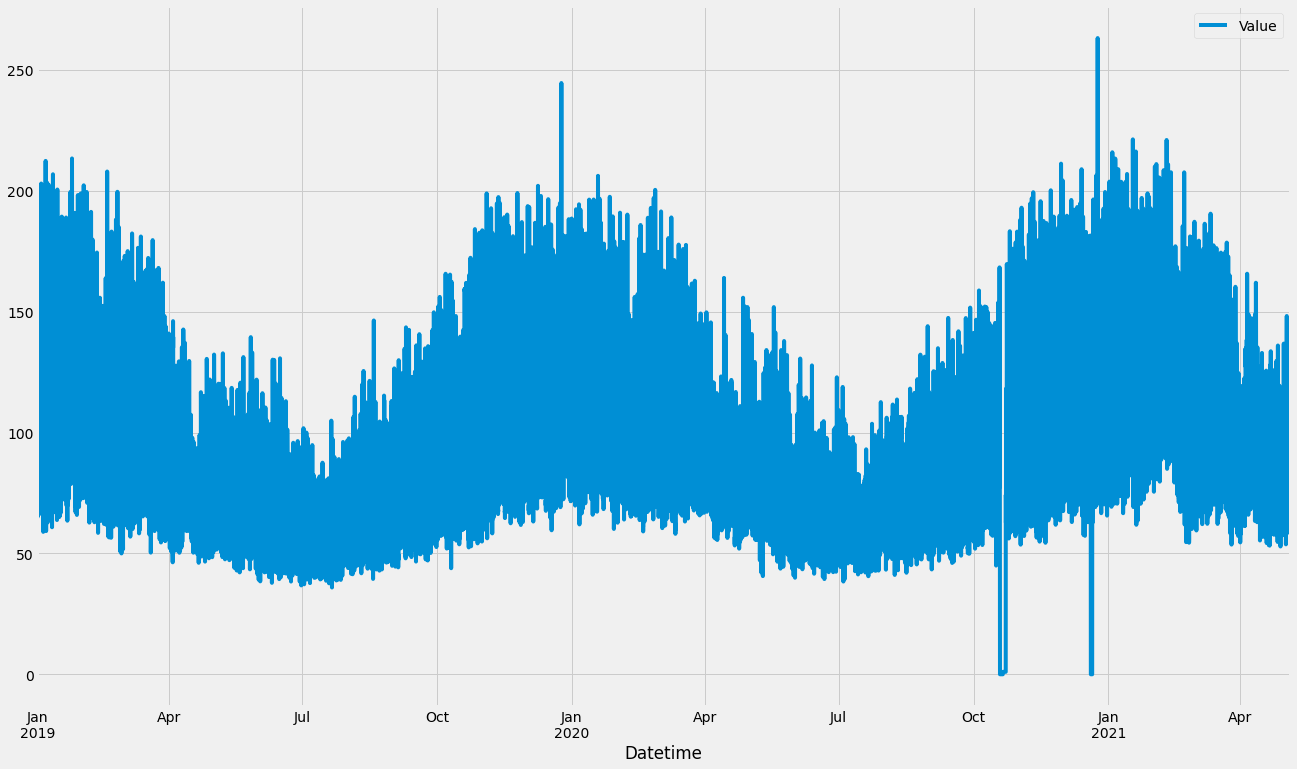

In [4]:
kld.plot()
plt.show()

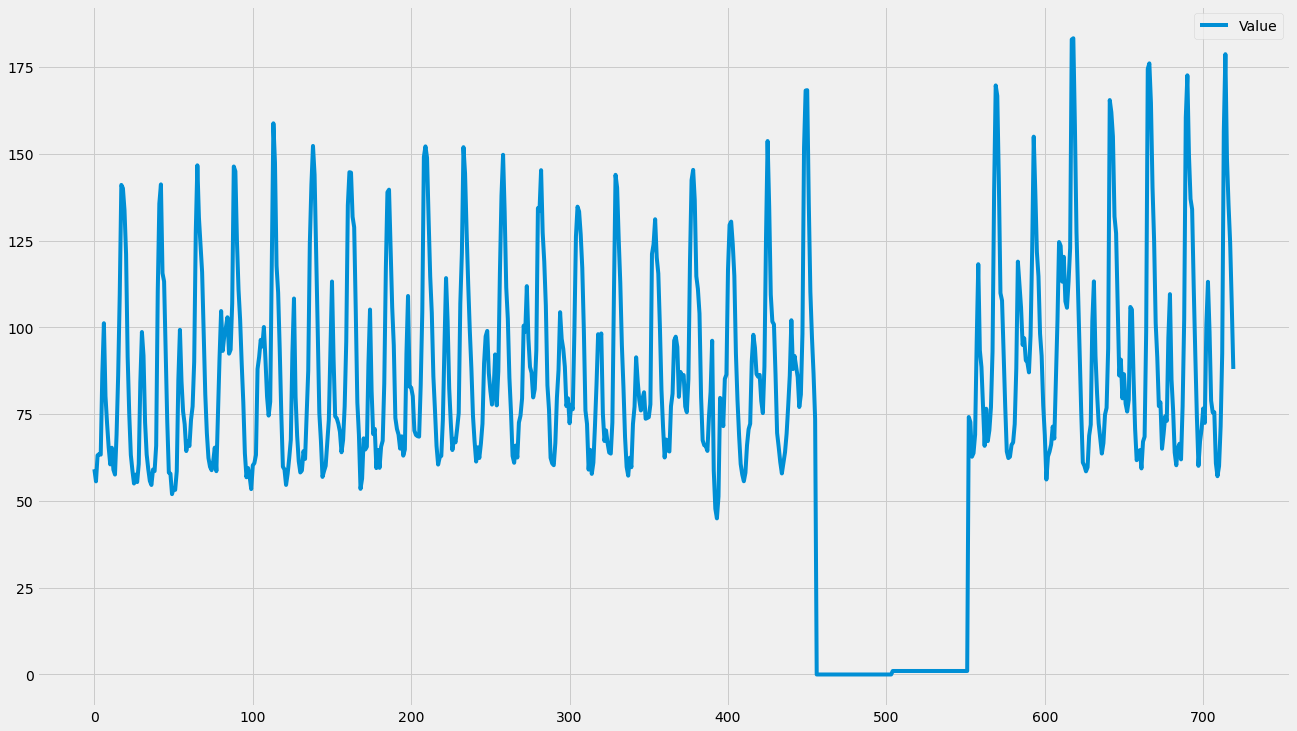

In [5]:
pd.read_csv('../data/kolding/7_kld_202010.csv', index_col=None, header=0).plot()
plt.show()

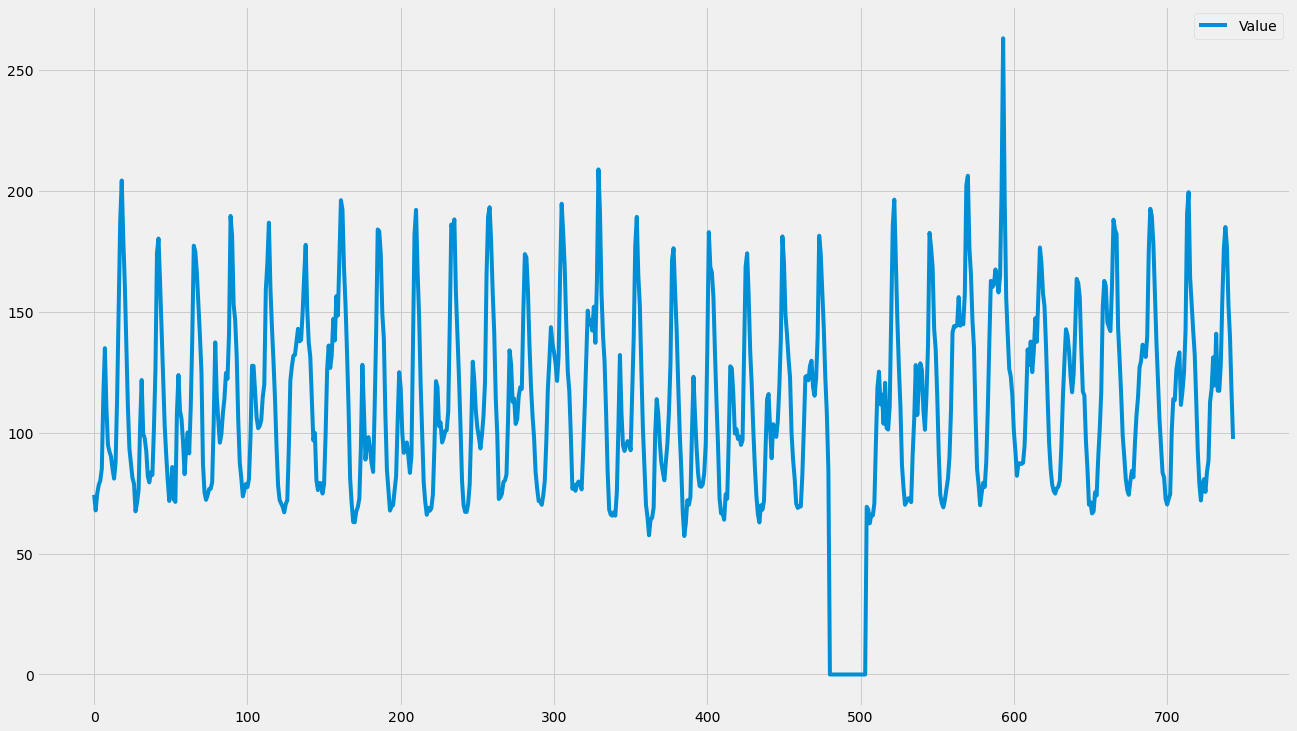

In [6]:
pd.read_csv('../data/kolding/9_kld_202012.csv', index_col=None, header=0).plot()
plt.show()

The plots show two time periods where there is missing data. In the October plot the missing data runs over a 4-day period; one day showing zeros and the next day shows a constant low value of 1.01.  
The december data shows a constant 0 aswell.

In [7]:
def replacenan(df):
    nans = df[df.Value < 10]['Value'].unique()
    for nan in nans:
        df.replace(nan, np.nan, inplace=True)

replacenan(kld)

In [8]:
np.unique(kld[kld['Value'].isna() == True].index.date)

array([datetime.date(2020, 10, 19), datetime.date(2020, 10, 20),
       datetime.date(2020, 10, 21), datetime.date(2020, 10, 22),
       datetime.date(2020, 12, 20)], dtype=object)

In [9]:
print(kld[kld.Value.isna()].index.day.unique())
print(kld[kld.Value.isna()].index.month.unique())

Int64Index([19, 20, 21, 22], dtype='int64', name='Datetime')
Int64Index([10, 12], dtype='int64', name='Datetime')


In [10]:
print(kld[kld.index == dt.datetime(2020,10,19)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,10,20)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,10,21)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,10,22)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,12,19)].index.dayofweek)
print(kld[kld.index == dt.datetime(2020,12,20)].index.dayofweek)

Int64Index([0], dtype='int64', name='Datetime')
Int64Index([1], dtype='int64', name='Datetime')
Int64Index([2], dtype='int64', name='Datetime')
Int64Index([3], dtype='int64', name='Datetime')
Int64Index([5], dtype='int64', name='Datetime')
Int64Index([6], dtype='int64', name='Datetime')


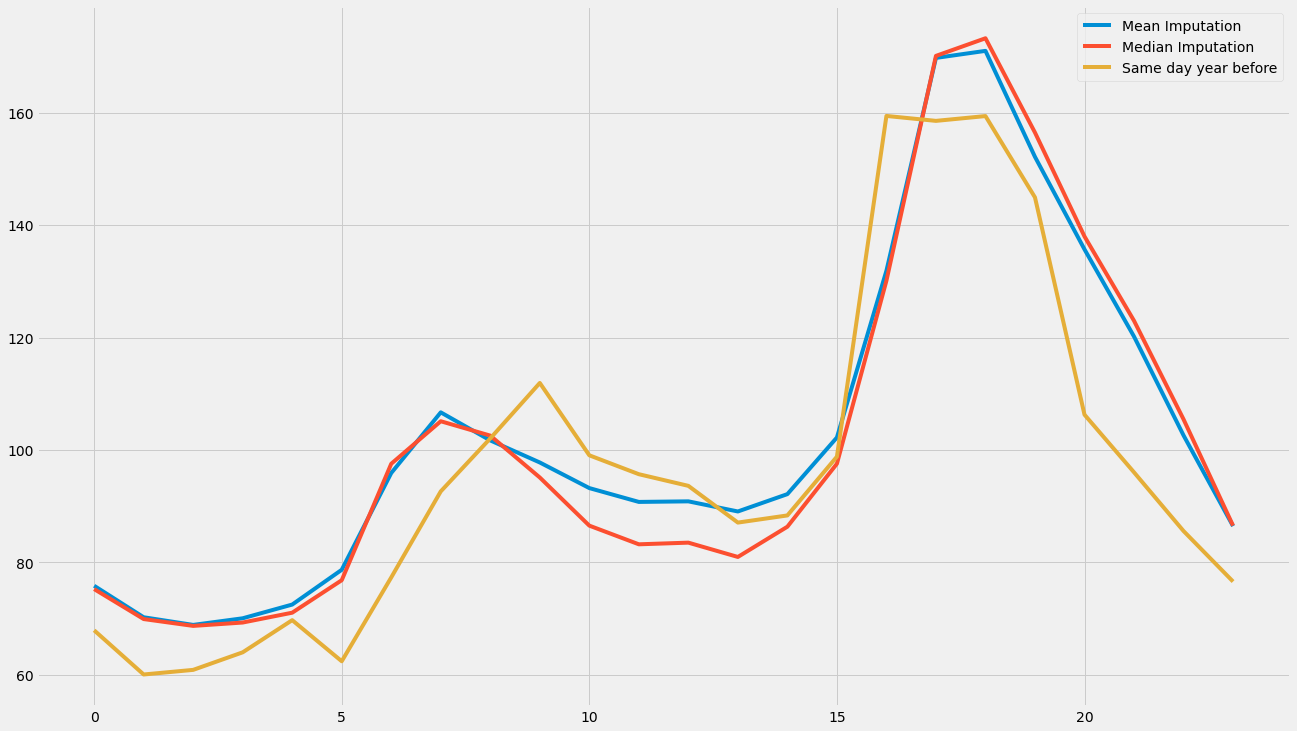

In [11]:
mn = []
md = []
sameday = kld[(kld.index >= dt.datetime(2019,10,19)) & (kld.index < dt.datetime(2019,10,20))].Value.tolist()
for t in range(24):
    mn.append(kld[(kld.index.hour == t) & (kld.index.quarter == 4)].mean()[0])
    md.append(kld[(kld.index.hour == t) & (kld.index.quarter == 4)].median()[0])
    

plt.plot(mn, label='Mean Imputation')
plt.plot(md, label='Median Imputation')
plt.plot(sameday, label='Same day year before')
plt.legend()
plt.show()

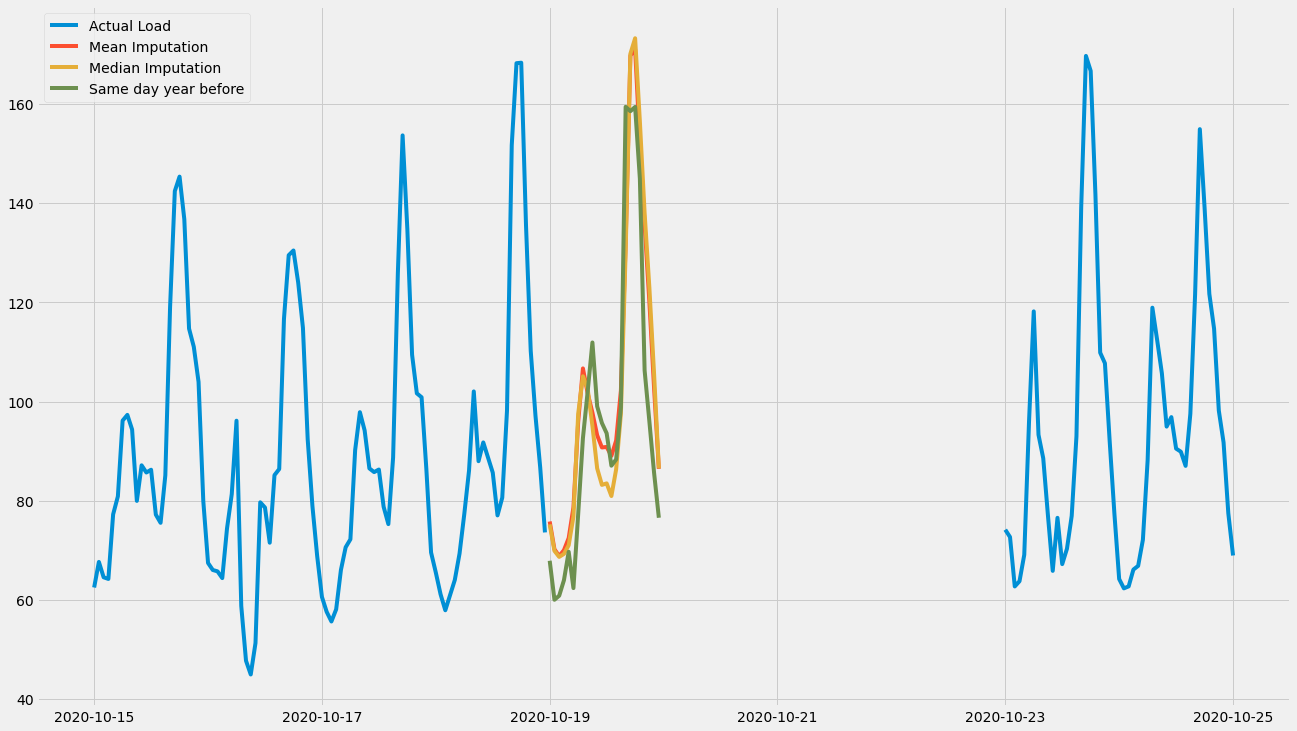

In [12]:
x = pd.date_range('2020-10-19', '2020-10-20', freq='H')
octkld = kld[(kld.index >= dt.datetime(2020,10,15)) & (kld.index <= dt.datetime(2020,10,25))]

plt.plot(octkld, label='Actual Load')
plt.plot(x[:-1], mn, label='Mean Imputation')
plt.plot(x[:-1], md, label='Median Imputation')
plt.plot(x[:-1], sameday, label='Same day year before')
plt.legend()
plt.show()

There are many ways to impute missing values for time series. The challenges for this dataset is the trend, seasonality and behavior of patterns in the data.  


In [13]:
def fillnans(df):
    for date in np.unique(df[df['Value'].isna() == True].index.date):
        df[df.index.date == date] = df[df.index.date == date - dt.timedelta(days=366)].values #leap year
    return df

In [14]:
kld = fillnans(kld)

# Preparing Strib Data

In [15]:
# Load Data
path = r'../data/strib/'
files = glob.glob(path + "/*.csv")

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    dfs.append(df)

stb = pd.concat(dfs, axis=0, ignore_index=True)
stb.Datetime = pd.to_datetime(stb.Datetime)
stb = stb.groupby('Datetime').sum()

## Handling Missing Values

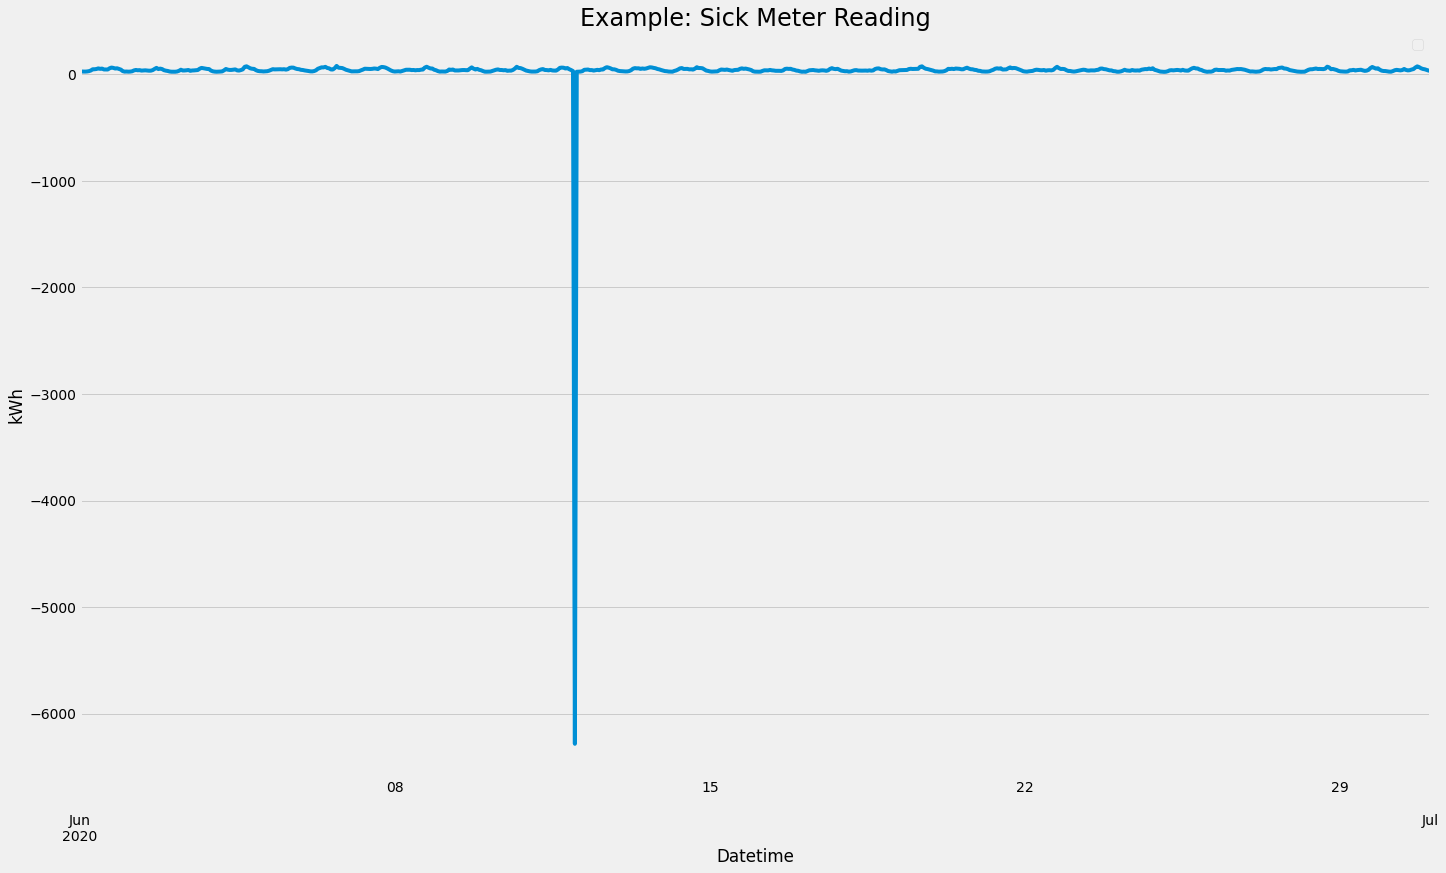

In [16]:
stb.loc[dt.date(2020,6,1):dt.date(2020,7,1)].plot()
plt.tight_layout()
plt.title('Example: Sick Meter Reading', fontsize=24)
plt.legend('')
plt.ylabel('kWh')
plt.savefig('visuals/sick_meter_example.png', bbox_inches = "tight")
plt.show()

Large negative values are a result of "sick" meters or meter resetting.

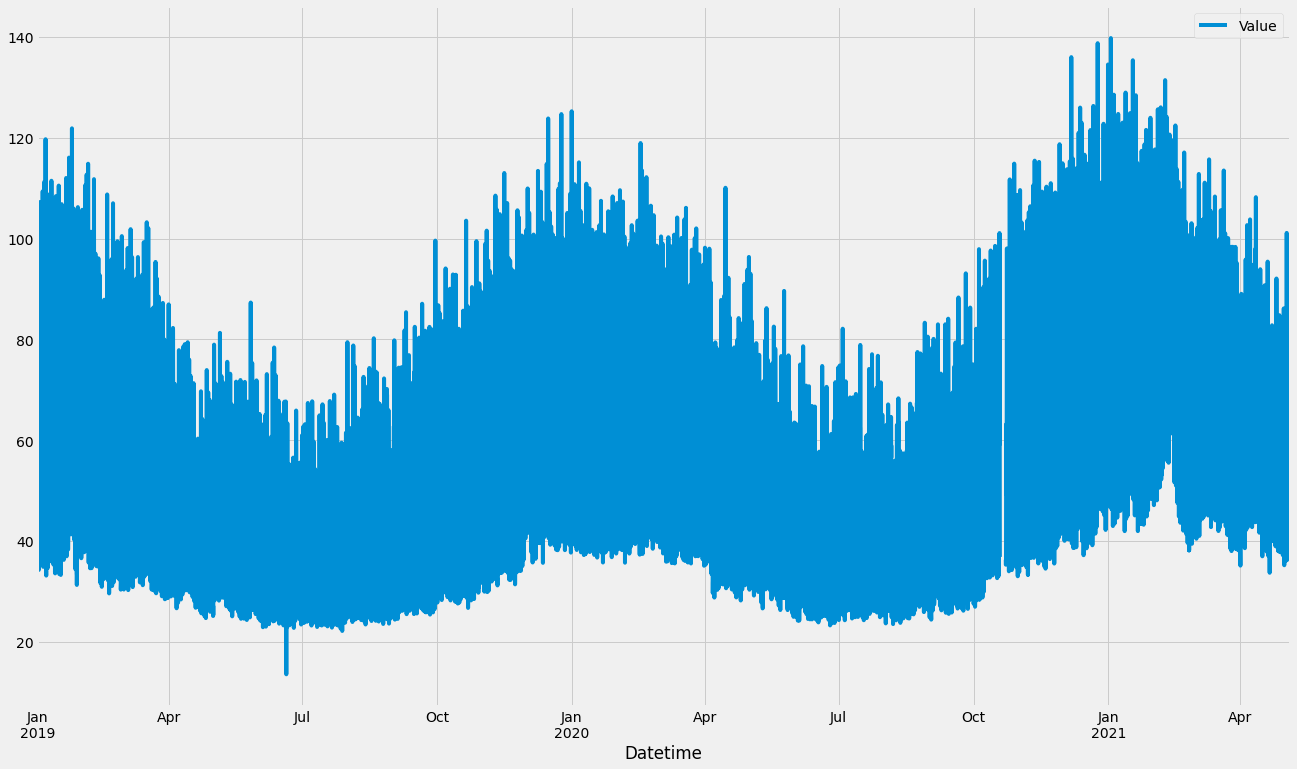

In [17]:
replacenan(stb)

stb.plot()
plt.show()

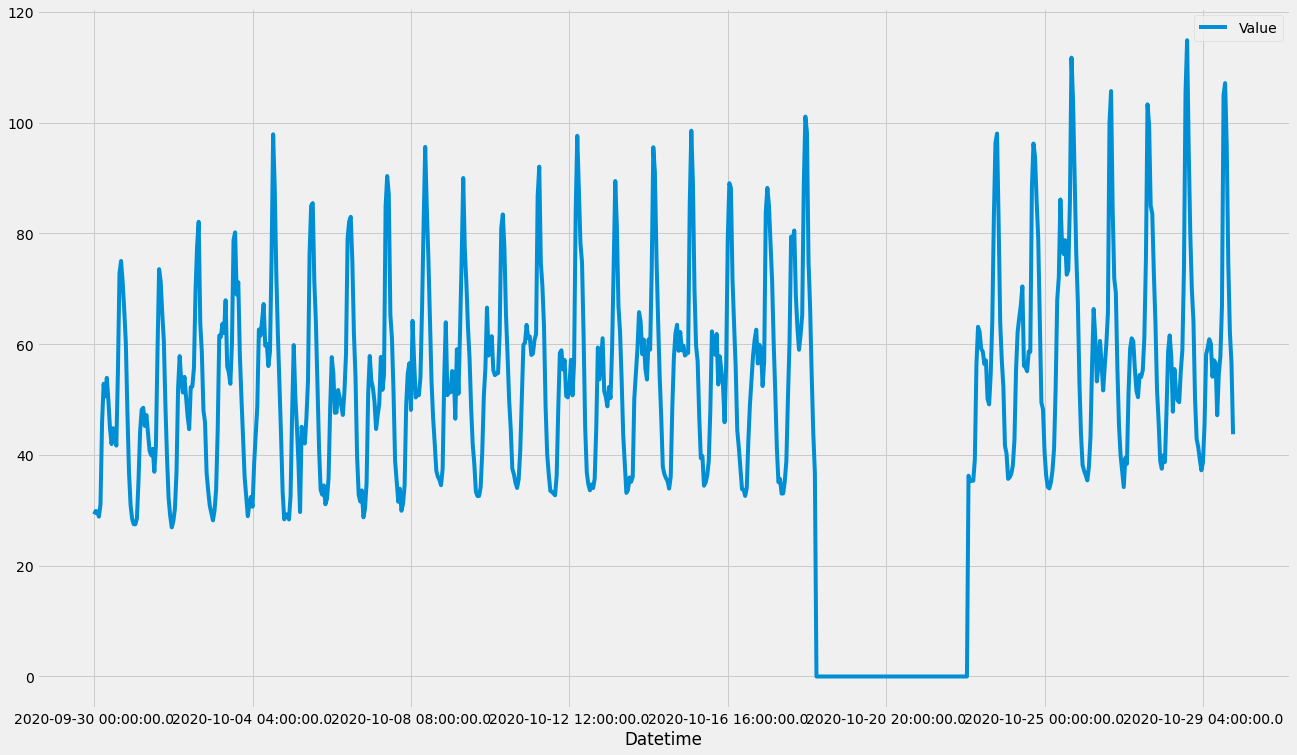

In [18]:
pd.read_csv('../data/strib/7_stb_202010.csv', index_col=None, header=0).groupby('Datetime').sum().plot()
plt.show()

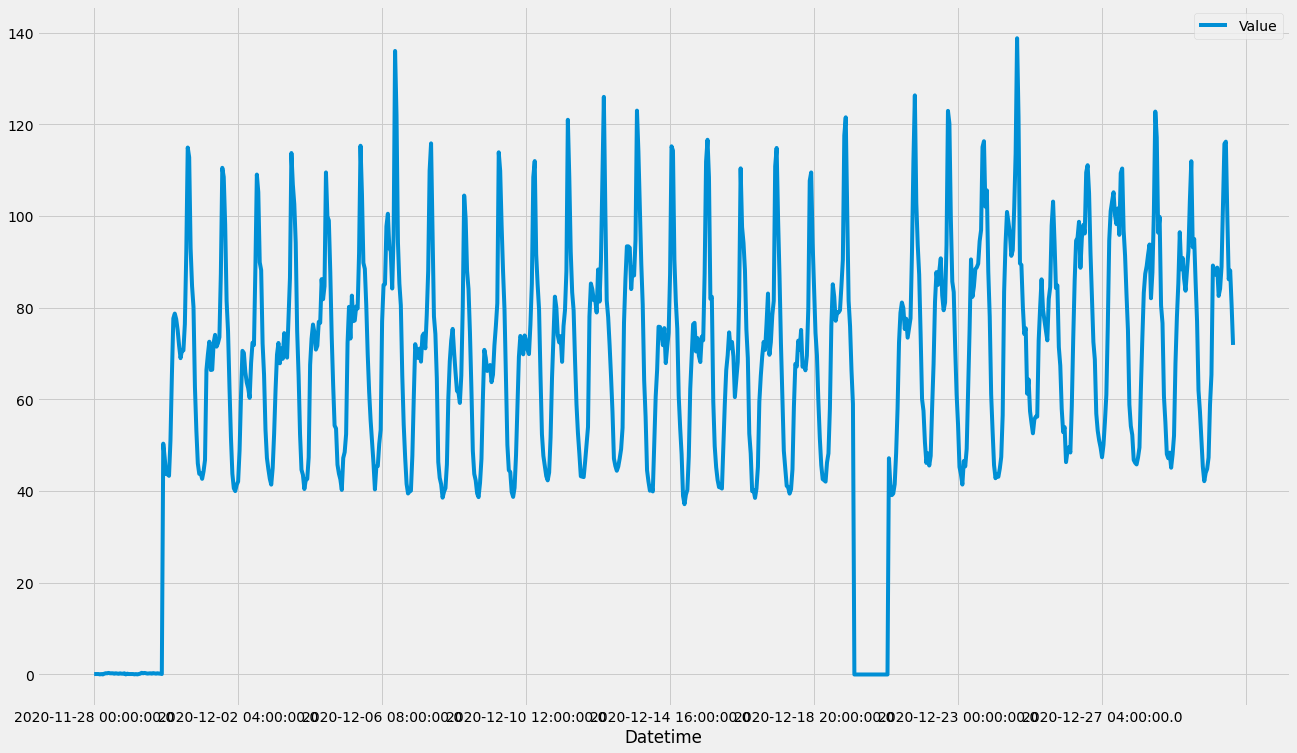

In [19]:
pd.read_csv('../data/strib/9_stb_202012.csv', index_col=None, header=0).groupby('Datetime').sum().plot()
plt.show()

In [20]:
stb = fillnans(stb)

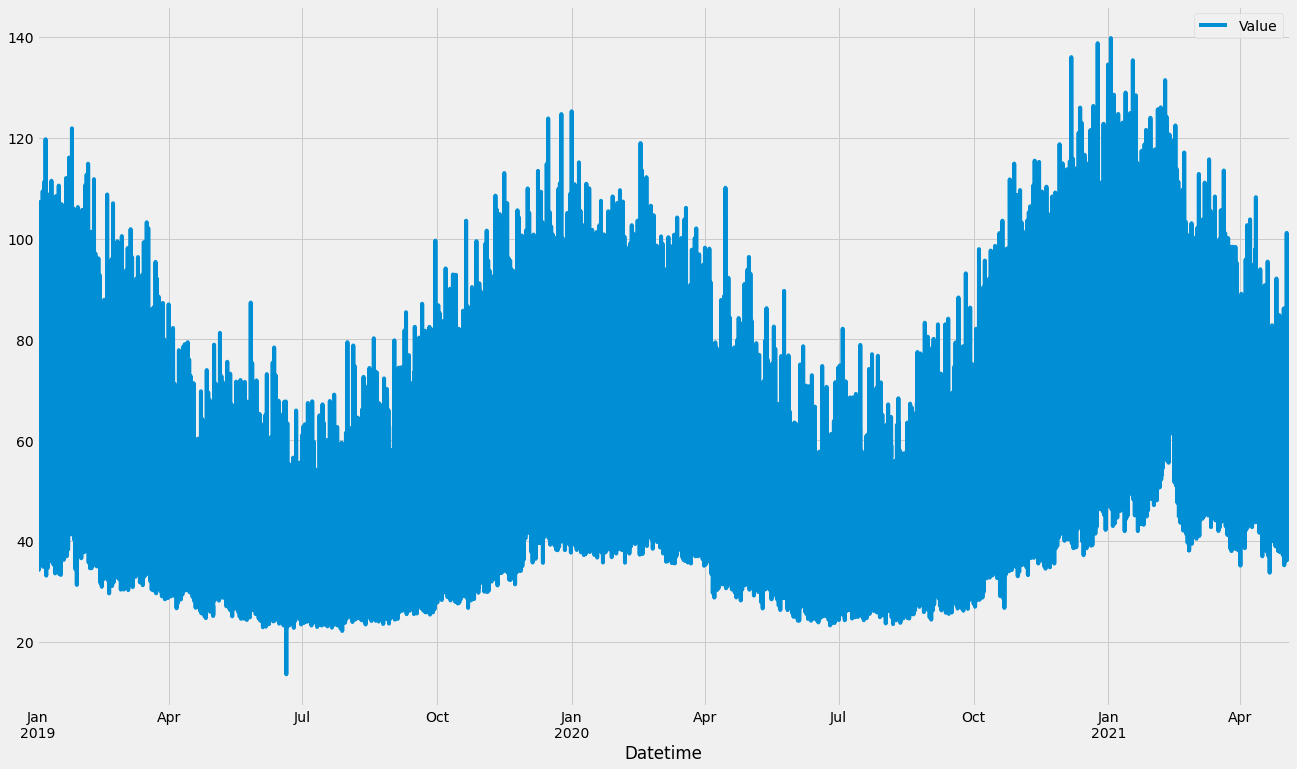

In [21]:
stb.plot()
plt.show()

### Introducing Weather Data

In [22]:
# Load Weather Data
weather = pd.read_csv('../data/weather_features.csv', header=0)
weather.Datetime = pd.to_datetime(weather.Datetime)
weather = weather.set_index('Datetime').sort_index()
#weather = weather[weather.index <= kld.index.max()]

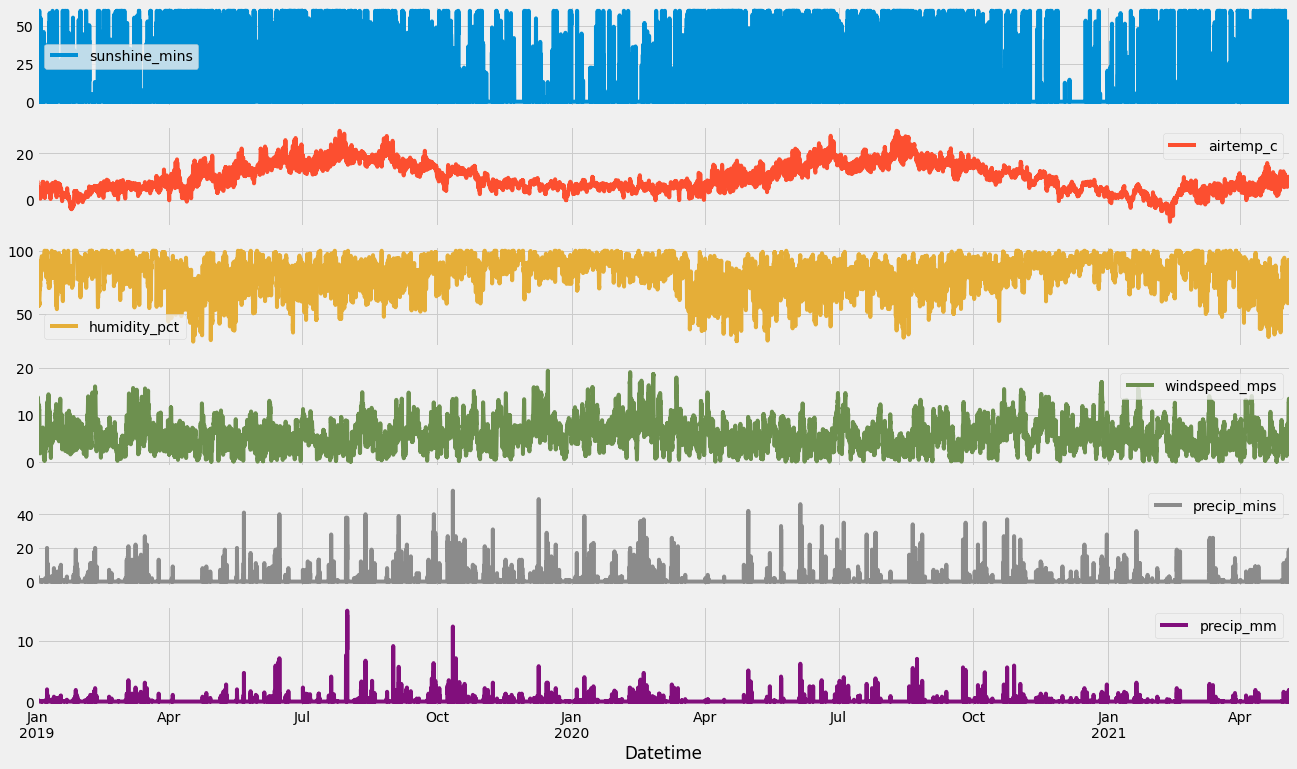

In [23]:
weather.plot(subplots=True)
plt.show()

In [24]:
kld_features = pd.merge(kld, weather, left_index=True, right_index=True)

In [25]:
stb_features = pd.merge(stb, weather, left_index=True, right_index=True)

### Daylength Data (Photoperiod)

In [26]:
daylengths = pd.read_csv('../data/daylengths.csv').transpose().iloc[1:]
daylengths.reset_index(inplace=True)
daylengths.columns = ['date', 'daylength_hrs']

daylengths['date'] = daylengths['date'].apply(lambda row: row[1:])
daylengths['date'] = pd.to_datetime(daylengths['date'], format='%Y.%m.%d')

daylengths.set_index('date', inplace=True)

daylengths.head()

,daylength_hrs
date,
2019-01-01,7.148307
2019-01-02,7.171043
2019-01-03,7.195853
2019-01-04,7.222702
2019-01-05,7.251554


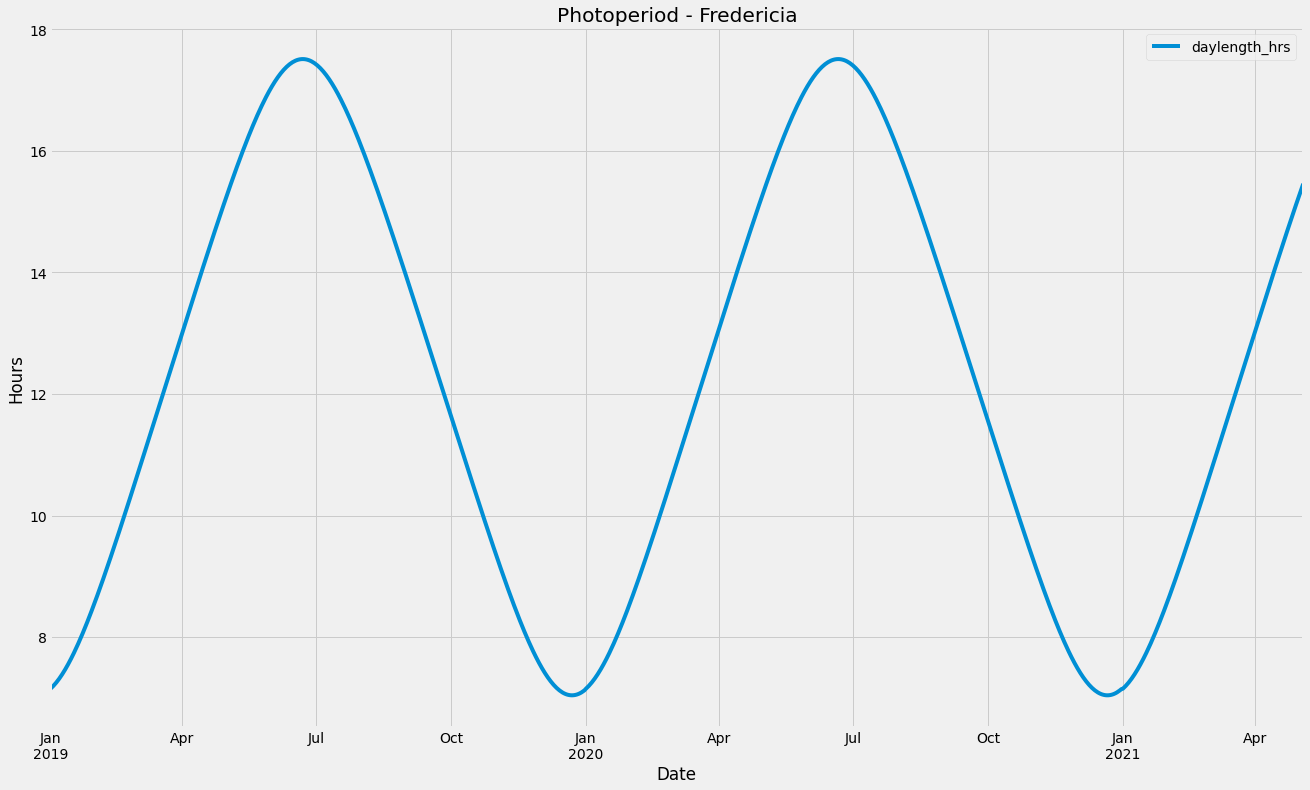

In [27]:
daylengths.plot()
plt.title('Photoperiod - Fredericia')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.show()

In [28]:
kld_features = pd.merge(kld_features, daylengths, how='left', left_index=True, right_index=True)
kld_features['daylength_hrs'] = kld_features['daylength_hrs'].fillna(method='ffill')

In [29]:
stb_features = pd.merge(stb_features, daylengths, how='left', left_index=True, right_index=True)
stb_features['daylength_hrs'] = stb_features['daylength_hrs'].fillna(method='ffill')

### Weekday Feature


In [30]:
kld_features['wkdy'] = ''
kld_features['wkdy'] = kld_features.apply(lambda row: row.index.dayofweek)
kld_features.head()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs,wkdy
Datetime,,,,,,,,,
2019-01-01 00:00:00,116.322,0.0,7.850000,87.833333,11.716667,0.0,0.0,7.148307,1
2019-01-01 01:00:00,102.681,0.0,7.883333,88.500000,11.983333,0.0,0.0,7.148307,1
2019-01-01 02:00:00,96.379,0.0,7.850000,91.500000,11.183333,0.0,0.0,7.148307,1
2019-01-01 03:00:00,85.352,0.0,7.983333,93.500000,10.516667,0.0,0.0,7.148307,1
2019-01-01 04:00:00,74.842,0.0,8.166667,83.333333,12.666667,1.0,0.1,7.148307,1


In [31]:
stb_features['wkdy'] = ''
stb_features['wkdy'] = stb_features.apply(lambda row: row.index.dayofweek)
stb_features.head()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs,wkdy
Datetime,,,,,,,,,
2019-01-01 00:00:00,67.056,0.0,7.850000,87.833333,11.716667,0.0,0.0,7.148307,1
2019-01-01 01:00:00,56.467,0.0,7.883333,88.500000,11.983333,0.0,0.0,7.148307,1
2019-01-01 02:00:00,54.711,0.0,7.850000,91.500000,11.183333,0.0,0.0,7.148307,1
2019-01-01 03:00:00,49.146,0.0,7.983333,93.500000,10.516667,0.0,0.0,7.148307,1
2019-01-01 04:00:00,42.688,0.0,8.166667,83.333333,12.666667,1.0,0.1,7.148307,1


In [32]:
#
kld_features['wkdy_sin'] = np.sin(kld_features['wkdy'] * (2 * np.pi / kld_features['wkdy'].max()))
kld_features['wkdy_cos'] = np.cos(kld_features['wkdy'] * (2 * np.pi / kld_features['wkdy'].max()))
#
stb_features['wkdy_sin'] = np.sin(stb_features['wkdy'] * (2 * np.pi / stb_features['wkdy'].max()))
stb_features['wkdy_cos'] = np.cos(stb_features['wkdy'] * (2 * np.pi / stb_features['wkdy'].max()))

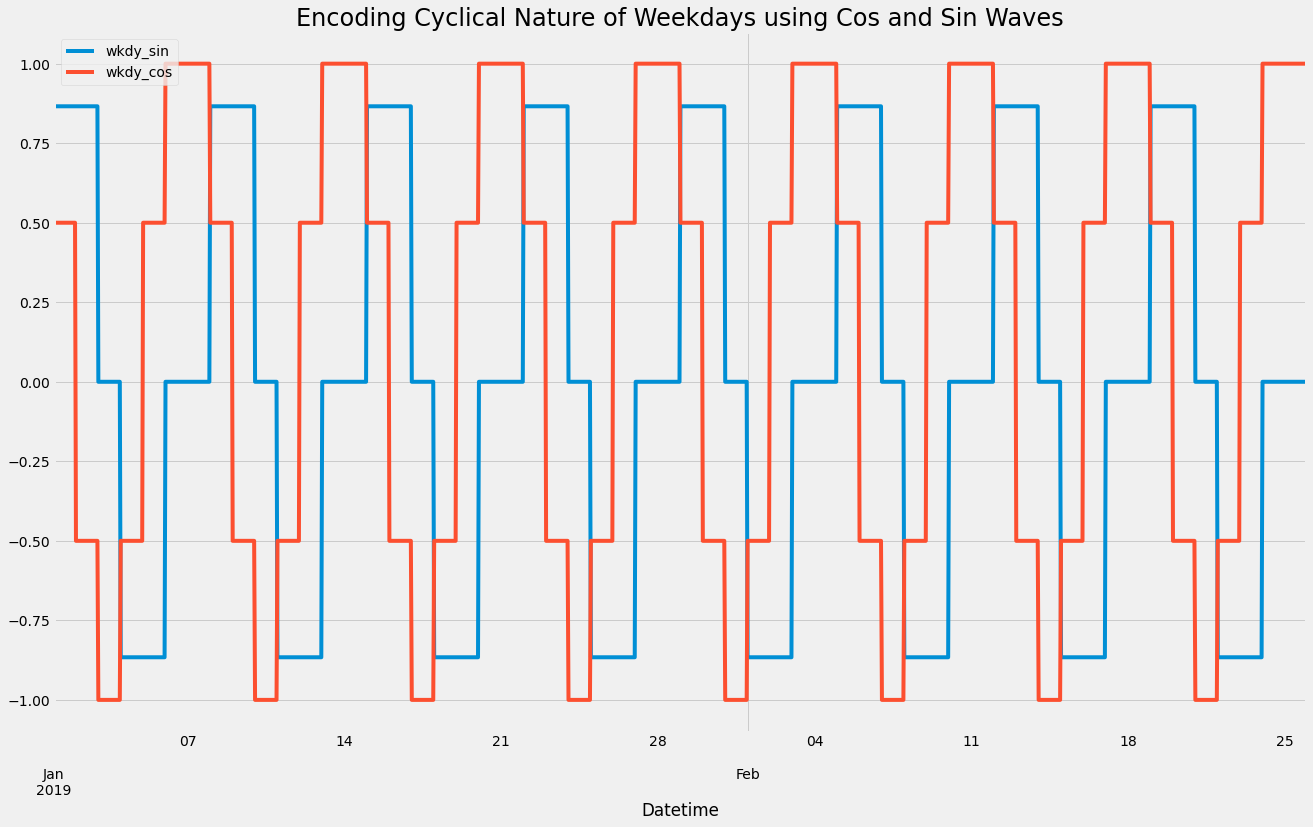

In [33]:
kld_features[['wkdy_sin','wkdy_cos']].iloc[:24*7*8].plot()
plt.title('Encoding Cyclical Nature of Weekdays using Cos and Sin Waves', fontsize=24)
plt.savefig('visuals/weekday_feature_cyclic.png', bbox_inches = "tight")
plt.show()

#### Weekend 

In [34]:
# Because weekends have different patterns than weekdays
kld_features['wknd'] = kld_features['wkdy'].apply(lambda row: 1 if row >= 5 else 0)
stb_features['wknd'] = stb_features['wkdy'].apply(lambda row: 1 if row >= 5 else 0)

#### Months - Seasonality

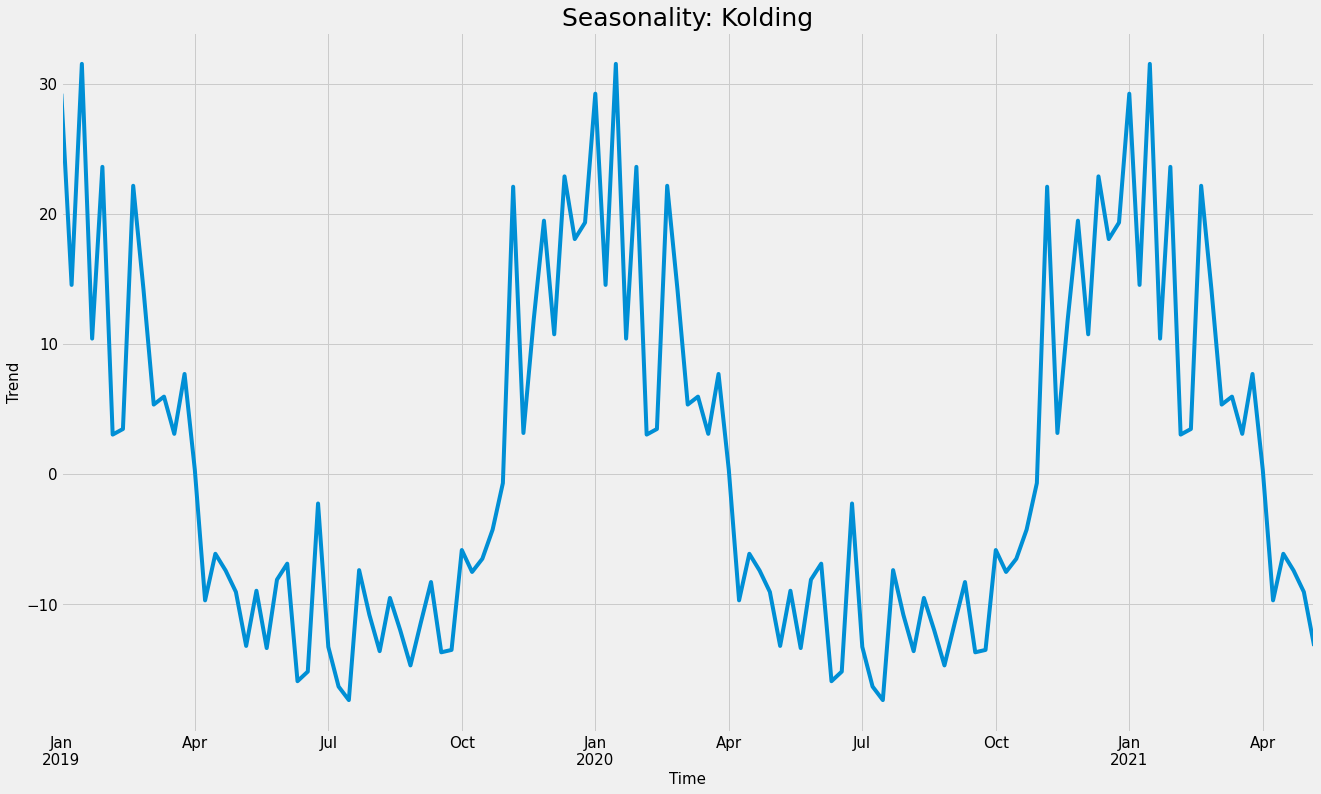

In [35]:
weekly = kld_features['Value'].resample('W').interpolate()
weekly_decomp = sm.tsa.seasonal_decompose(weekly)
seasonality = weekly_decomp.seasonal
ax = seasonality.plot(fontsize=15)
ax.set_title('Seasonality: Kolding', fontsize=25)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Trend', fontsize=15)
plt.show()


In [36]:
kld_features['mnth'] = ''
kld_features['mnth'] = kld_features.apply(lambda row: row.index.month)

stb_features['mnth'] = ''
stb_features['mnth'] = stb_features.apply(lambda row: row.index.month)

In [37]:
kld_features['mnth_sin'] = np.sin(kld_features['mnth'] * (2 * np.pi / kld_features['mnth'].max()))
kld_features['mnth_cos'] = np.cos(kld_features['mnth'] * (2 * np.pi / kld_features['mnth'].max()))

stb_features['mnth_sin'] = np.sin(stb_features['mnth'] * (2 * np.pi / stb_features['mnth'].max()))
stb_features['mnth_cos'] = np.cos(stb_features['mnth'] * (2 * np.pi / stb_features['mnth'].max()))

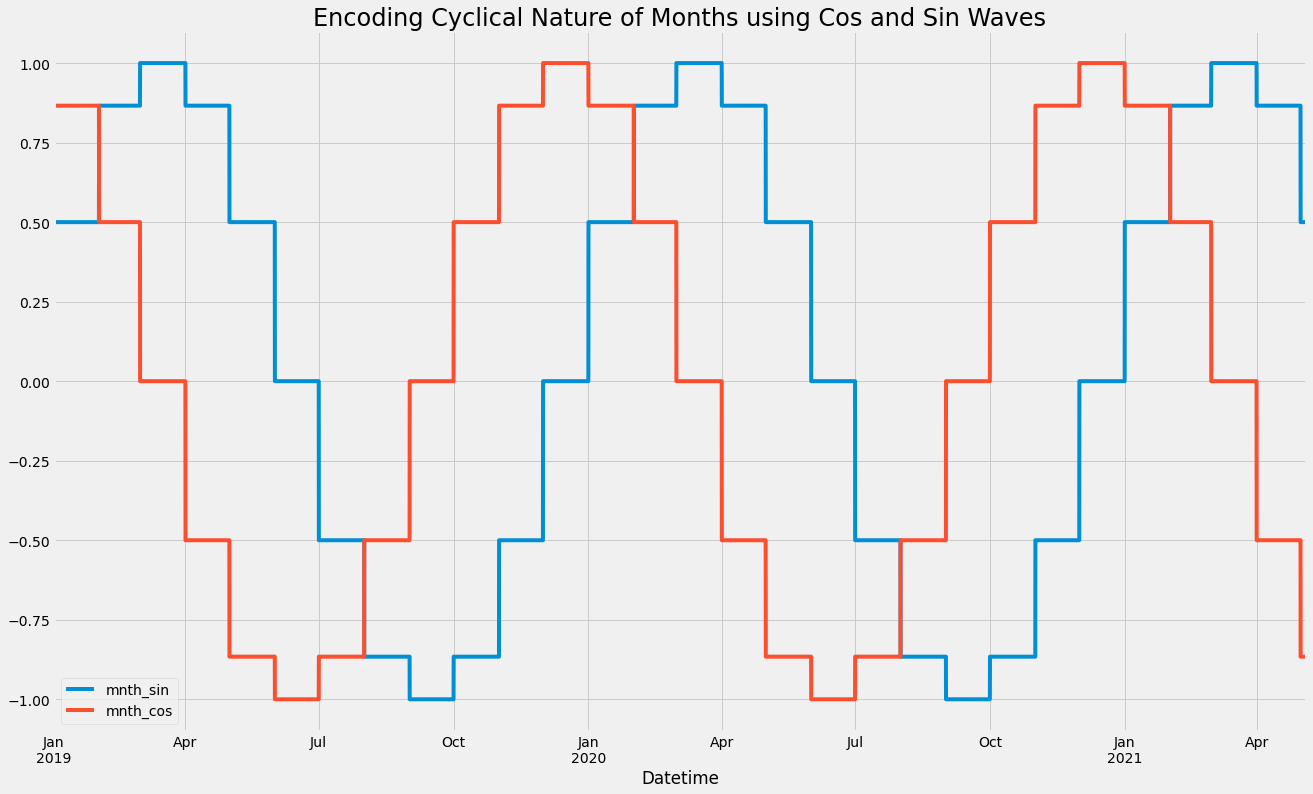

In [38]:
kld_features[['mnth_sin','mnth_cos']].plot()
plt.title('Encoding Cyclical Nature of Months using Cos and Sin Waves', fontsize=24)
plt.savefig('visuals/month_feature_cyclic.png', bbox_inches = "tight")
plt.show()

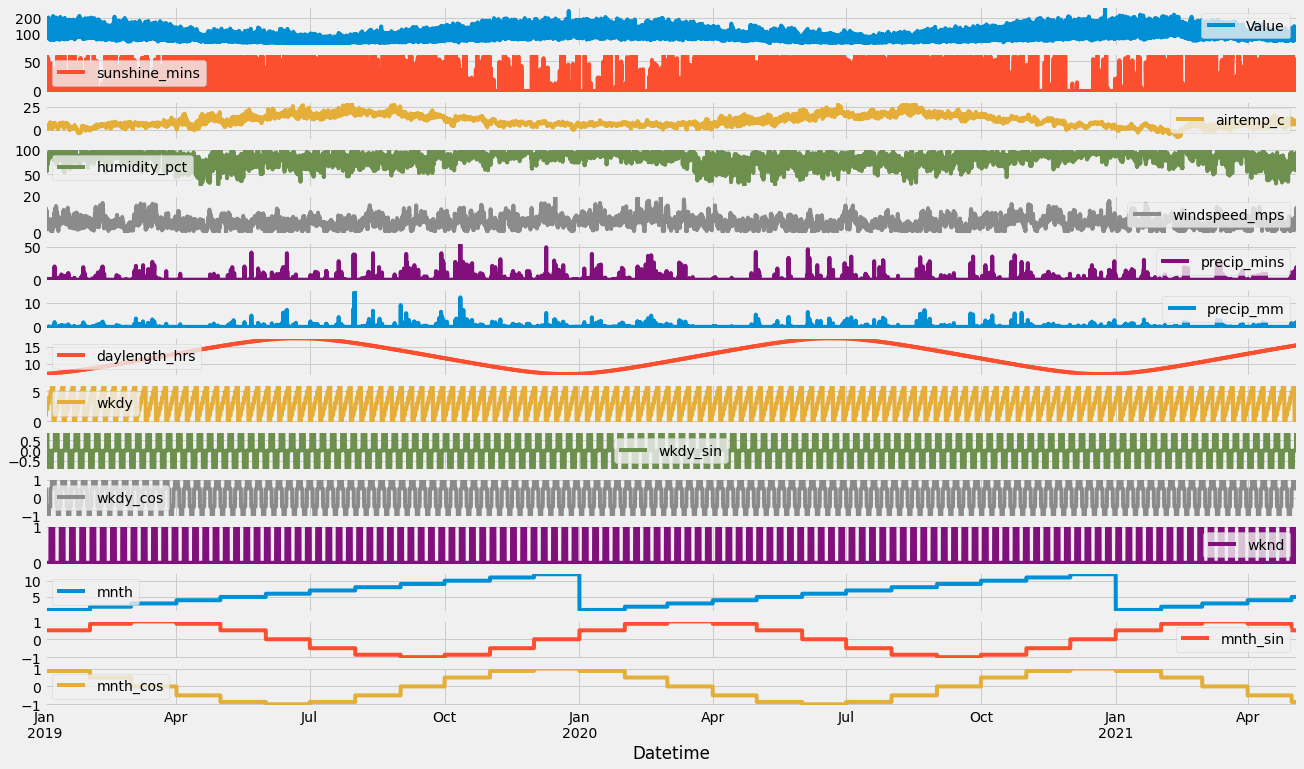

In [39]:
kld_features.plot(subplots=True)
plt.show()

In [40]:
kld_features.describe()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs,wkdy,wkdy_sin,wkdy_cos,wknd,mnth,mnth_sin,mnth_cos
count,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,2.052000e+04,2.052000e+04
mean,89.865986,12.534016,9.455829,82.438075,5.773409,0.695468,0.082047,12.114236,2.997661,0.001013,0.143275,0.285380,5.948538,1.118916e-01,2.473758e-02
std,32.083370,21.518293,6.035450,12.777505,2.943939,2.941160,0.412935,3.451328,2.000047,0.654956,0.741992,0.451606,3.507761,7.147706e-01,6.899416e-01
min,35.904000,0.000000,-9.416667,28.166667,0.000000,0.000000,0.000000,7.040866,0.000000,-0.866025,-1.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00
25%,66.281000,0.000000,5.000000,75.166667,3.633333,0.000000,0.000000,8.851576,1.000000,-0.866025,-0.500000,0.000000,3.000000,-5.000000e-01,-5.000000e-01
50%,82.219500,0.000000,8.033333,85.000000,5.466667,0.000000,0.000000,12.026706,3.000000,0.000000,0.500000,0.000000,6.000000,1.224647e-16,6.123234e-17
75%,106.837250,18.000000,14.166667,92.166667,7.550000,0.000000,0.000000,15.251250,5.000000,0.866025,1.000000,1.000000,9.000000,8.660254e-01,8.660254e-01
max,263.164000,60.000000,29.566667,100.000000,19.400000,54.000000,14.900000,17.512735,6.000000,0.866025,1.000000,1.000000,12.000000,1.000000e+00,1.000000e+00


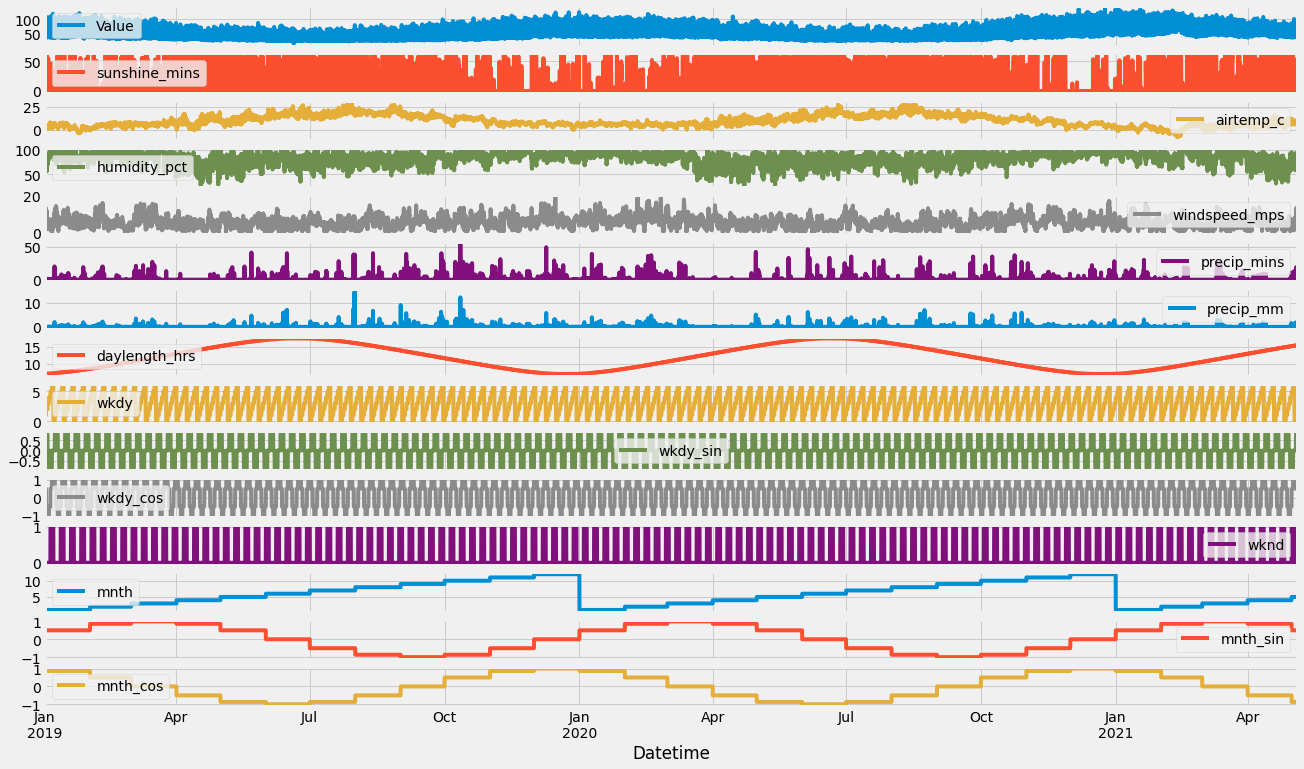

In [41]:
stb_features.plot(subplots=True)
plt.show()

In [42]:
stb_features.describe()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs,wkdy,wkdy_sin,wkdy_cos,wknd,mnth,mnth_sin,mnth_cos
count,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,20520.000000,2.052000e+04,2.052000e+04
mean,54.462405,12.534016,9.455829,82.438075,5.773409,0.695468,0.082047,12.114236,2.997661,0.001013,0.143275,0.285380,5.948538,1.118916e-01,2.473758e-02
std,19.240769,21.518293,6.035450,12.777505,2.943939,2.941160,0.412935,3.451328,2.000047,0.654956,0.741992,0.451606,3.507761,7.147706e-01,6.899416e-01
min,13.515000,0.000000,-9.416667,28.166667,0.000000,0.000000,0.000000,7.040866,0.000000,-0.866025,-1.000000,0.000000,1.000000,-1.000000e+00,-1.000000e+00
25%,40.137250,0.000000,5.000000,75.166667,3.633333,0.000000,0.000000,8.851576,1.000000,-0.866025,-0.500000,0.000000,3.000000,-5.000000e-01,-5.000000e-01
50%,51.213500,0.000000,8.033333,85.000000,5.466667,0.000000,0.000000,12.026706,3.000000,0.000000,0.500000,0.000000,6.000000,1.224647e-16,6.123234e-17
75%,65.496750,18.000000,14.166667,92.166667,7.550000,0.000000,0.000000,15.251250,5.000000,0.866025,1.000000,1.000000,9.000000,8.660254e-01,8.660254e-01
max,139.792000,60.000000,29.566667,100.000000,19.400000,54.000000,14.900000,17.512735,6.000000,0.866025,1.000000,1.000000,12.000000,1.000000e+00,1.000000e+00


In [43]:
kld_features.to_csv('../data/processed/kolding_features.csv', header=True)
stb_features.to_csv('../data/processed/strib_features.csv', header=True)

In [44]:
pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs,wkdy,wkdy_sin,wkdy_cos,wknd,mnth,mnth_sin,mnth_cos
Datetime,,,,,,,,,,,,,,,
2019-01-01 00:00:00,116.322,0.0,7.850000,87.833333,11.716667,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 01:00:00,102.681,0.0,7.883333,88.500000,11.983333,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 02:00:00,96.379,0.0,7.850000,91.500000,11.183333,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 03:00:00,85.352,0.0,7.983333,93.500000,10.516667,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 04:00:00,74.842,0.0,8.166667,83.333333,12.666667,1.0,0.1,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-04 19:00:00,122.368,0.0,7.950000,88.000000,8.633333,1.0,0.1,15.459791,1,0.866025,0.5,0,5,0.5,-0.866025
2021-05-04 20:00:00,122.692,0.0,7.683333,90.166667,7.250000,0.0,0.0,15.459791,1,0.866025,0.5,0,5,0.5,-0.866025
2021-05-04 21:00:00,102.106,0.0,7.650000,92.333333,7.233333,0.0,0.0,15.459791,1,0.866025,0.5,0,5,0.5,-0.866025


In [45]:
pd.read_csv('../data/processed/strib_features.csv', index_col='Datetime', parse_dates=['Datetime'])

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm,daylength_hrs,wkdy,wkdy_sin,wkdy_cos,wknd,mnth,mnth_sin,mnth_cos
Datetime,,,,,,,,,,,,,,,
2019-01-01 00:00:00,67.056,0.0,7.850000,87.833333,11.716667,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 01:00:00,56.467,0.0,7.883333,88.500000,11.983333,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 02:00:00,54.711,0.0,7.850000,91.500000,11.183333,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 03:00:00,49.146,0.0,7.983333,93.500000,10.516667,0.0,0.0,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
2019-01-01 04:00:00,42.688,0.0,8.166667,83.333333,12.666667,1.0,0.1,7.148307,1,0.866025,0.5,0,1,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-04 19:00:00,70.472,0.0,7.950000,88.000000,8.633333,1.0,0.1,15.459791,1,0.866025,0.5,0,5,0.5,-0.866025
2021-05-04 20:00:00,69.720,0.0,7.683333,90.166667,7.250000,0.0,0.0,15.459791,1,0.866025,0.5,0,5,0.5,-0.866025
2021-05-04 21:00:00,58.206,0.0,7.650000,92.333333,7.233333,0.0,0.0,15.459791,1,0.866025,0.5,0,5,0.5,-0.866025
